# 5.1 Criação de Modelos de Machine Learning - Tunning

## Carregar dados tratados

In [1]:
# ! pip install seaborn
# ! pip install plotly
# ! pip install statsmodels
# ! pip install sklearn

In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split


from sklearn.metrics import classification_report, confusion_matrix, recall_score

from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import RandomizedSearchCV

import joblib

In [3]:
def carregar_joblib(file_name: str = "../out/result_analise_desc.joblib"):
    df = joblib.load(file_name)
    return df

In [34]:
def plot_confusion_matrix_heat(cf_matrix):
    cf_matrix.index.name = 'Atual'
    cf_matrix.columns.name = 'Predito'
    
    cf_nd_array = cf_matrix.to_numpy()
    cf_flatten = cf_nd_array.flatten()

    group_names = ["TN", "FP", "FN", "TP"]
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_flatten]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_flatten / np.sum(cf_nd_array)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    print(cf_matrix.shape)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')


In [35]:
def avaliar(y_teste, y_prev, nome_modelo):
    print(nome_modelo)
    print("Reporte teste")
    report = classification_report(y_teste, y_prev, target_names=["Vender", "Comprar"])
    print(report)
    cf_matrix = pd.DataFrame(confusion_matrix(y_teste, y_prev), index=["Vender", "Comprar"], columns=["Vender", "Comprar"])
    plot_confusion_matrix_heat(cf_matrix)
    plt.show()
    print("Recall: ", recall_score(y_teste, y_prev))
    print("#" * 50)
    return recall_score(y_teste, y_prev)


# ML modelo

In [5]:
def definir_modelo_ml() -> dict:
    return {
        "AdaBoost": {'modelo_base': AdaBoostClassifier(random_state=42), 'modelo_tunado': None},
        # "AdaBoost": {'modelo_base': AdaBoostClassifier(random_state=42, n_estimators=50, learning_rate=0.1, algorithm='SAMME'), 'modelo_tunado': None},
           }

In [6]:
def treinar_modelo_base(df, modelos):

    # split database train and test
    X = df.drop(["decisao"], axis=1)
    y = df["decisao"]

    X_treino, _, y_treino, _ = train_test_split(X, y, test_size=0.15, random_state=2)

    for nome, modelo in modelos.items():
        modelo = modelo.get('modelo_base')
        modelo.fit(X_treino, y_treino)

        modelos[nome]['modelo_base'] = modelo
    
    return modelos

## Tunning do modelo

In [12]:
def fit_tunning_rand_search_ada(X_treino, y_treino):
    print("Tunning randomized search AdaBoost")

    # Create the random grid
    param = {'n_estimators': [50, 80, 90, 100],
             'learning_rate': [0.2, 1.0, 0.1],
             'algorithm': ["SAMME", "SAMME.R"]}

    print(param)

    rf_random = RandomizedSearchCV(estimator=AdaBoostClassifier(),
                                   param_distributions=param,
                                   cv=3,
                                   verbose=0,
                                   scoring="precision",
                                   random_state=42,
                                   n_jobs=-1)

    # Fit the random search model
    return rf_random.fit(X_treino, y_treino)

In [8]:

def run_ada_boost_tunning(df):

    X = df.drop(["decisao"], axis=1)
    y = df["decisao"]

    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.15, random_state=2)
    
    resultado_grid = fit_tunning_rand_search_ada(X_treino.values, y_treino.values)

    print("Ajuste Adaboost feito")

    print("Best params", resultado_grid.best_params_)
    print("Best score", resultado_grid.best_score_)

    modelo_tunado = resultado_grid.best_estimator_

    return modelo_tunado

In [9]:
def compare_tunning(df, modelos: dict):

    X = df.drop(["decisao"], axis=1)
    y = df["decisao"]

    _, X_teste, _, y_teste = train_test_split(X, y, test_size=0.15, random_state=2)

    recalls = {}
    for nome, modelos_dict in modelos.items():
        prev = modelos_dict['modelo_base'].predict(X_teste)
        recalls[nome + '_base'] =  avaliar(y_teste, prev, nome + '_base')
        prev = modelos_dict['modelo_tunado'].predict(X_teste)
        recalls[nome + '_tunned'] = avaliar(y_teste, prev, nome + '_tunado')
    
    # barplot comparacao 3 modelos tunados
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x=list(recalls.keys()), y=list(recalls.values()))
    ax.set(xlabel="Modelos", ylabel="Recall", title="Recall por Modelo")
    

In [10]:
def run_tunning_fit(df, modelos):
    '''
        Executa os tunnings com randomized search cv e armazena o modelo tunado
    '''
    modelos['AdaBoost']['modelo_tunado'] = run_ada_boost_tunning(df)

    return modelos


Tunning randomized search AdaBoost
{'n_estimators': [50, 80, 90, 100], 'learning_rate': [0.2, 1.0, 0.1], 'algorithm': ['SAMME', 'SAMME.R']}
Ajuste Adaboost feito
Best params {'n_estimators': 80, 'learning_rate': 0.2, 'algorithm': 'SAMME'}
Best score 0.5629828621640408
AdaBoost_base
Reporte teste
              precision    recall  f1-score   support

      Vender       0.56      0.44      0.50       142
     Comprar       0.52      0.64      0.58       136

    accuracy                           0.54       278
   macro avg       0.54      0.54      0.54       278
weighted avg       0.54      0.54      0.54       278

(2, 2)


/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


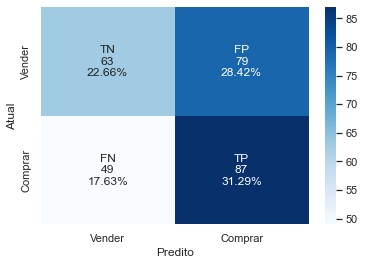

Recall:  0.6397058823529411
##################################################
AdaBoost_tunado
Reporte teste
              precision    recall  f1-score   support

      Vender       0.55      0.37      0.44       142
     Comprar       0.51      0.69      0.59       136

    accuracy                           0.53       278
   macro avg       0.53      0.53      0.51       278
weighted avg       0.53      0.53      0.51       278

(2, 2)


/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


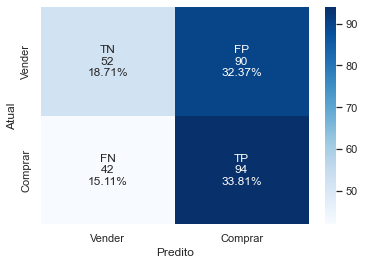

Recall:  0.6911764705882353
##################################################


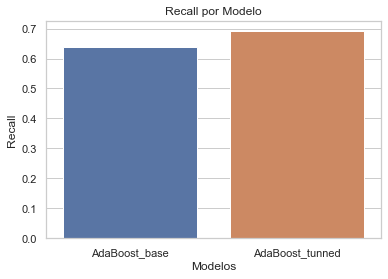

In [36]:
def main():

    df = carregar_joblib()

    modelo = definir_modelo_ml()

    modelo = treinar_modelo_base(df, modelo)

    modelo = run_tunning_fit(df, modelo)

    compare_tunning(df, modelo)

    return df, modelo

df, modelos = main()